In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [3]:
import SenseEmb
import SenseEmb.sense_clust as sclust

In [4]:
skv = SenseEmb.SenseKeyedVectors.load_from_kv("../data/sense-emb-asbc5-600k-d50.kv")

In [5]:
import umap
import hdbscan
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib
import numpy as np
import numpy.linalg as la
from tqdm.auto import tqdm
import json
from scipy.spatial import Delaunay, ConvexHull, Voronoi
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, single, dendrogram
from sklearn.decomposition import PCA

In [6]:
matplotlib.rcParams["font.family"] = "Microsoft JhengHei"
matplotlib.rcParams['axes.unicode_minus']=False

## What are the measures in semantic space
* community structure
  1. number of cluster
* volume of sense, must project into low dimension (how low?)
  > Don't try to work on full data in full dimensions  
  
  2. volume of the word
  3. volume of each cluster (based on voronoid region)
  4. volume of each senses

## Singular values of full sense space

cut point (.7/.8/.9/.95):  [4, 8, 17, 27]


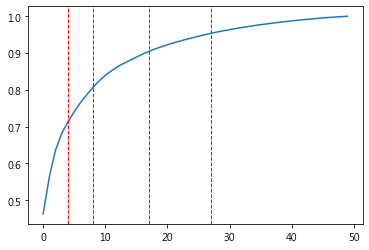

In [40]:
full_mat = skv.vectors
singular_vals = la.svd(full_mat, full_matrices=False)[1]
frob_norm = np.sqrt((singular_vals**2).sum())
vars_explained = np.sqrt((singular_vals**2).cumsum())/frob_norm
sv_cuts = [np.argmax(vars_explained > thres) for thres in [.7, .8, .9, .95]]
ax = plt.plot(vars_explained)
for val in sv_cuts:
    plt.axvline(val, linestyle='--', linewidth=1, color='r')    
print("cut point (.7/.8/.9/.95): ", sv_cuts)

## In single word

In [7]:
sdata = skv.make_sense_vectors("條")
svecs = sdata.sense_vecs
svecs.shape

(19, 50)

cut point (.7/.8/.9/.95):  [0, 0, 2, 5]


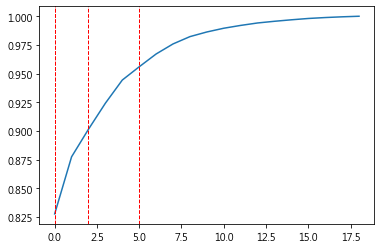

In [18]:
singular_vals = la.svd(svecs)[1]
frob_norm = np.sqrt((singular_vals**2).sum())
vars_explained = np.sqrt((singular_vals**2).cumsum())/frob_norm
sv_cuts = [np.argmax(vars_explained > thres) for thres in [.7, .8, .9, .95]]
ax = plt.plot(vars_explained)
for val in sv_cuts:
    plt.axvline(val, linestyle='--', linewidth=1, color='r')    
print("cut point (.7/.8/.9/.95): ", sv_cuts)

## Compute word volumes

In [25]:
pca_svecs = PCA(2).fit_transform(svecs)
hull = ConvexHull(pca_svecs)

volume: 0.57


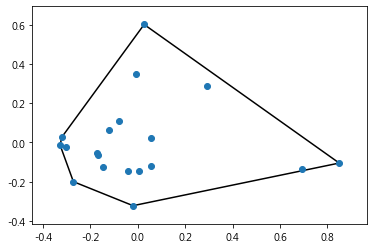

In [42]:
from scipy.spatial import convex_hull_plot_2d, voronoi_plot_2d
convex_hull_plot_2d(hull);
print("volume: %.2f" % (hull.volume))

## Compute sense volume

In [44]:
vor.point_region

array([13,  5, 19,  3, 17,  8, 18, 16,  9,  7, 15, 12, 14, 10,  0,  4,  6,
       11,  1], dtype=int64)

In [45]:
vor.regions[13]

[24, 6, 14, 22]

In [86]:
hull.vertices

array([16, 18,  4,  9,  2, 13], dtype=int32)

in_open_region:  [2, 4, 9, 13, 16, 18]
convex hull vertices [2, 4, 9, 13, 16, 18]
all_region_volumes:  2.9134393100993043


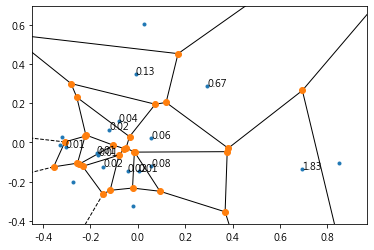

In [98]:
vor = Voronoi(pca_svecs)
_, ax = plt.subplots(1, 1)
voronoi_plot_2d(vor, ax=ax);
sense_vols = np.zeros(vor.npoints)
in_open_region = []
for i, reg_num in enumerate(vor.point_region):
    indices = vor.regions[reg_num]
    if -1 in indices:
        sense_vols[i] = np.inf
        in_open_region.append(i)
    else:
        sense_vols[i] = ConvexHull(vor.vertices[indices]).volume
        ax.text(*vor.points[i], s="{:.2f}".format(sense_vols[i]))
print("in_open_region: ", sorted(in_open_region))
print("convex hull vertices", sorted(hull.vertices))
all_regions_volume = sense_vols[np.isfinite(sense_vols)].sum()
print("all_region_volumes: ", all_regions_volume)

[]

## Compute community structure

In [144]:
dict(a="a") | dict(b='b')

TypeError: unsupported operand type(s) for |: 'dict' and 'dict'

In [125]:
n_neigh = int(np.round(np.sqrt(svecs.shape[0])))
uinst = umap.UMAP(n_components=2, n_neighbors=n_neigh, min_dist=0.0, transform_mode="graph", metric="cosine")
uinst.fit(pca_svecs)
graph = uinst.graph_
# proj = uinst.embedding_

In [126]:
rhos, sigmas = uinst._rhos, uinst._sigmas

In [127]:
slabels = [f"{i}. {x}" for i, x in enumerate(sdata.sense_labels)]

In [128]:
dists = pdist(svecs, metric="cosine")
link_mat = single(dists)
link_mat[:, 0:2]
leave_orders = dendrogram(link_mat, no_plot=True)["leaves"]

label_xmat = np.empty((len(slabels),len(slabels)), dtype=object)
label_ymat = np.empty((len(slabels),len(slabels)), dtype=object)
for i, sidx in enumerate(leave_orders):
    label_xmat[i, :] = slabels[sidx]
    label_ymat[:, i] = slabels[sidx]
label_data = np.dstack((label_xmat, label_ymat))

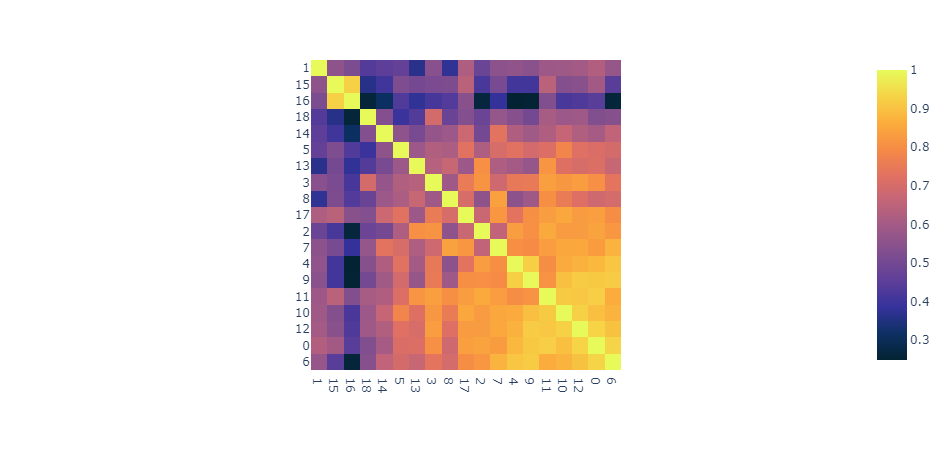

In [129]:

fig = px.imshow(1-(squareform(dists)[leave_orders, :][:, leave_orders]),          
          x=[str(x) for x in np.arange(svecs.shape[0])[leave_orders]],          
          y=[str(x) for x in np.arange(svecs.shape[0])[leave_orders]],            
          color_continuous_scale=px.colors.sequential.thermal,
         )

fig.update(data=[{"customdata": label_data, 
                 "hovertemplate": (
                     '%{x}, %{y}, %{z} <br>'
                     'x-sense: %{customdata[1]} <br>'
                     'y-sense: %{customdata[0]}')}])
fig.show()

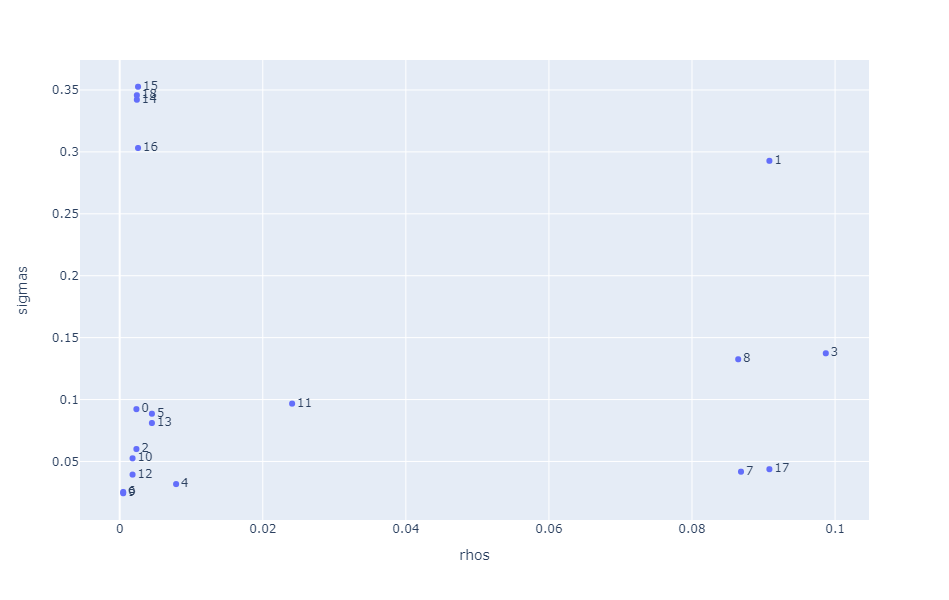

In [130]:
fig = px.scatter(dict(rhos=rhos, sigmas=sigmas, labels=slabels, text=np.arange(len(rhos))), 
                 x="rhos", y="sigmas", hover_data=["labels"], text="text",
                 width=600, height=600)
fig.update_traces(textposition="middle right")
fig.show()
# plt.scatter(rhos, sigmas)
# for i in range(len(rhos)):
#     plt.text(rhos[i]*1.05, sigmas[i], str(i))

In [131]:
import igraph as ig

In [132]:
g2 = ig.Graph.Weighted_Adjacency(graph.todense(), mode="undirected")

In [133]:
vcs = g2.community_leading_eigenvector(weights="weight")
len(np.unique(vcs.membership))

5

In [134]:
coords = g2.layout_fruchterman_reingold()

In [135]:
import plotly.graph_objects as go

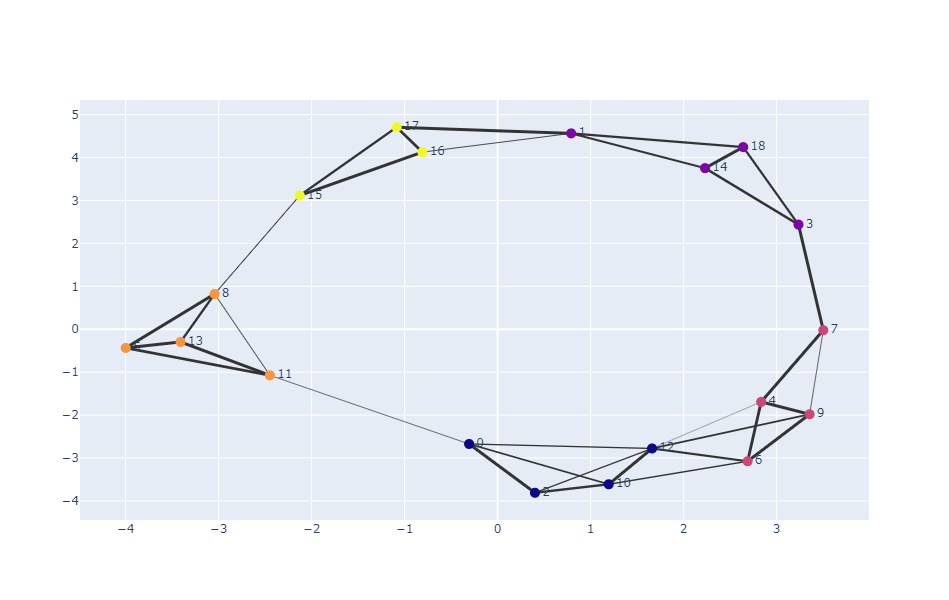

In [136]:
edge_traces = []
for e_x in g2.es:
    src = e_x.source
    tgt = e_x.target
    edge_trace_x = go.Scatter(
        x = [coords[src][0], coords[tgt][0]],
        y = [coords[src][1], coords[tgt][1]],
        line=dict(width=e_x["weight"]*3, color="#333"), 
        mode="lines"
    )
    edge_traces.append(edge_trace_x) 

coord_data = np.array(coords)
node_trace = go.Scatter(
    text=[str(x) for x in np.arange(coord_data.shape[0])], 
    customdata=slabels,
    x=coord_data[:,0], y=coord_data[:,1],
    mode="markers+text",
    textposition="middle right",
    hovertemplate='%{customdata}',
    marker=dict(size=10, color=vcs.membership),
    )
fig = go.Figure(data=[*edge_traces, node_trace])
fig.update_layout(showlegend=False, width=800, height=600)
fig.show()

In [141]:
dir(sdata)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'sense_freqs',
 'sense_ids',
 'sense_labels',
 'sense_vecs']

In [137]:
memberships = vcs.membership
sense_idxs = np.arange(len(memberships))
for clust_idx in np.unique(memberships):        
    vols = sense_vols[memberships == clust_idx]
    volume_clust = vols[np.isfinite(vols)].sum()
    vol_ratio = volume_clust/all_regions_volume
    print("--- Cluster %d (|V|/|V_all|: %.2f) ---" % (clust_idx, vol_ratio))
    for sidx in sense_idxs[memberships == clust_idx]:
        print(slabels[sidx])
    print("\n")

--- Cluster 0 (|V|/|V_all|: 0.01) ---
0. [06585903]計算形狀細而長的物體的單位。: 
2. [06585906]計算地面上長條型的建築物或自然景觀的單位。: 外有一<條>河，很
10. [06585916]計算船隻的單位。: 腳踏兩<條>船。
12. [06585921]計算顯示在特定平面上的線條或細長的紋路痕跡的單位。: 下畫了<條>粗線。


--- Cluster 1 (|V|/|V_all|: 0.29) ---
1. [06585905]計算盒裝香菸包裝成條狀販賣的單位。: 稅帶一<條>菸進來
3. [06585907]計算流體的單位。: 發現這<條>噴射流
14. [06585925]計算線索的單位。: 拋出幾<條>線索。
18. [06585933]計算歌曲的單位。: 


--- Cluster 2 (|V|/|V_all|: 0.01) ---
4. [06585908]計算動物的單位。: 牽著一<條>牛去殺
6. [06585910]計算身體部位的單位。: ，把整<條>手臂也
7. [06585911]計算動物性命的單位。: 貓有九<條>命。
9. [06585915]計算以布為主要材質的衣物的單位。: 爺做一<條>狼皮墊


--- Cluster 3 (|V|/|V_all|: 0.04) ---
5. [06585909]計算男子的單位。: 是83<條>男子漢
8. [06585912]計算人的心思意念的單位。: 應該一<條>心，為
11. [06585919]計算線狀物體的單位。: ，這三<條>線卻因
13. [06585924]計算行進的路線的單位。: 走那一<條>高速公


--- Cluster 4 (|V|/|V_all|: 0.65) ---
15. [06585928]計算以條列式呈現出的內容的單位。: 內」這<條>規定給
16. [06585930]計算法規結構分類的單位，在「節」之下、「項」之上。: 批准兩<條>法律以
17. [06585931]計算短篇文章的單位。: 過26<條>短文，




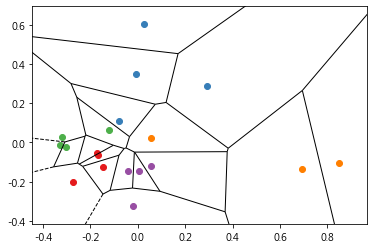

In [140]:
cm = plt.get_cmap("Set1")
fig, ax = plt.subplots(1, 1)
voronoi_plot_2d(vor, ax=ax, show_vertices=False, show_points=False);
memberships = vcs.membership
sense_idxs = np.arange(len(memberships))
for clust_idx in np.unique(memberships):        
    clust_points = vor.points[memberships == clust_idx]
    ax.scatter(clust_points[:, 0], clust_points[:, 1], color=cm.colors[clust_idx])
